c:\Users\uqkmuroi\gitcode\Torch-Practice\venv\Lib\site-packages\botorch\models\utils\assorted.py:264: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


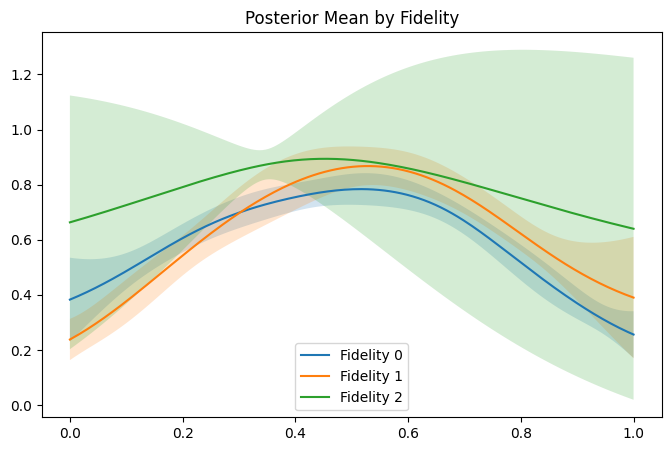

c:\Users\uqkmuroi\gitcode\Torch-Practice\venv\Lib\site-packages\botorch\acquisition\analytic.py:331: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
c:\Users\uqkmuroi\gitcode\Torch-Practice\venv\Lib\site-packages\botorch\acquisition\analytic.py:331: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
c:\Users\uqkmuroi\gitcode\Torch-Prac

Iteration 1: sampled fidelity 0 at x=0.533, y=0.856


c:\Users\uqkmuroi\gitcode\Torch-Practice\venv\Lib\site-packages\botorch\acquisition\analytic.py:331: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
c:\Users\uqkmuroi\gitcode\Torch-Practice\venv\Lib\site-packages\botorch\acquisition\analytic.py:331: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
c:\Users\uqkmuroi\gitcode\Torch-Prac

Iteration 2: sampled fidelity 0 at x=0.530, y=0.751
Iteration 3: sampled fidelity 0 at x=0.517, y=0.932


c:\Users\uqkmuroi\gitcode\Torch-Practice\venv\Lib\site-packages\botorch\acquisition\analytic.py:331: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
c:\Users\uqkmuroi\gitcode\Torch-Practice\venv\Lib\site-packages\botorch\acquisition\analytic.py:331: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
c:\Users\uqkmuroi\gitcode\Torch-Prac

Iteration 4: sampled fidelity 0 at x=0.515, y=0.913
Iteration 5: sampled fidelity 0 at x=0.520, y=0.830


c:\Users\uqkmuroi\gitcode\Torch-Practice\venv\Lib\site-packages\botorch\acquisition\analytic.py:331: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
c:\Users\uqkmuroi\gitcode\Torch-Practice\venv\Lib\site-packages\botorch\models\utils\assorted.py:264: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


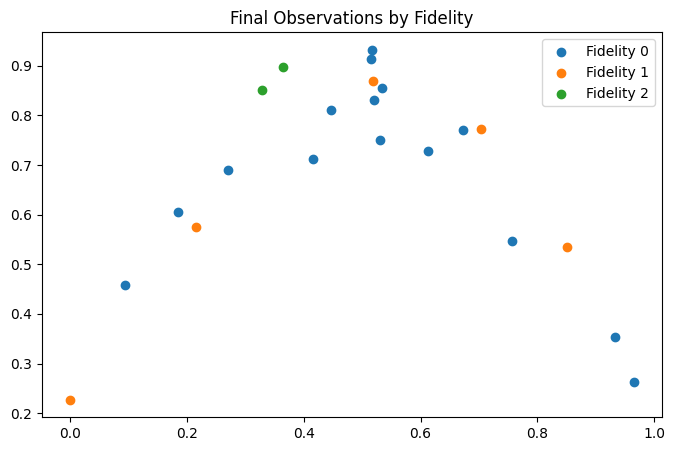

In [2]:
import torch
import matplotlib.pyplot as plt
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.optim import optimize_acqf
from torch.quasirandom import SobolEngine

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

# --- 1. Define ground-truth process ---
def true_yield(x):
    return torch.exp(-5 * (x - 0.5).pow(2)).sum(dim=-1, keepdim=True)

# --- 2. Fidelity simulation wrappers ---
def simulate_fidelity(x, fidelity):
    """Simulate fidelity-specific outputs with bias and noise"""
    true_val = true_yield(x)
    noise = {0: 0.10, 1: 0.05, 2: 0.01}[fidelity]
    bias = {0: 0.8, 1: 0.9, 2: 1.0}[fidelity]
    return bias * true_val + noise * torch.randn_like(true_val)

# --- 3. Generate initial data ---
sobol = SobolEngine(dimension=1, scramble=True)
n_low, n_mid, n_high = 10, 5, 2
x_low = sobol.draw(n_low).to(dtype).to(device)
x_mid = sobol.draw(n_mid).to(dtype).to(device)
x_high = sobol.draw(n_high).to(dtype).to(device)

y_low = simulate_fidelity(x_low, 0)
y_mid = simulate_fidelity(x_mid, 1)
y_high = simulate_fidelity(x_high, 2)

# --- 4. Stack input with fidelity index ---
def add_fidelity(x, level):
    f = torch.full_like(x, float(level))
    return torch.cat([x, f], dim=-1)

X_train = torch.cat([
    add_fidelity(x_low, 0),
    add_fidelity(x_mid, 1),
    add_fidelity(x_high, 2)
], dim=0).to(dtype).to(device)

Y_train = torch.cat([y_low, y_mid, y_high], dim=0).to(dtype).to(device)

# --- 5. Train the GP model ---
model = SingleTaskGP(X_train, Y_train,
    covar_module=ScaleKernel(MaternKernel(nu=2.5))
).to(device)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)

# --- 6. Visualize posterior mean across fidelities ---
test_x = torch.linspace(0, 1, 200).unsqueeze(-1).to(dtype).to(device)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for fidelity in [0, 1, 2]:
    test_X = torch.cat([test_x, torch.full_like(test_x, float(fidelity))], dim=-1)
    with torch.no_grad():
        post = model.posterior(test_X)
        mean = post.mean.cpu().squeeze()
        lower, upper = post.mvn.confidence_region()
        ax.plot(test_x.cpu(), mean, label=f"Fidelity {fidelity}")
        ax.fill_between(test_x.cpu().squeeze(), lower.cpu(), upper.cpu(), alpha=0.2)
ax.set_title("Posterior Mean by Fidelity")
ax.legend()
plt.show()

# --- 7. Acquisition function & selection ---
fidelity_costs = torch.tensor([1.0, 3.0, 10.0], device=device)

def select_next(model, fidelity, bounds):
    """Optimize EI for a given fidelity"""
    def construct_X(x_base):
        f = torch.full_like(x_base, float(fidelity))
        return torch.cat([x_base, f], dim=-1)

    fidelity_tensor = torch.tensor([[fidelity], [fidelity]], device=bounds.device, dtype=bounds.dtype)

    acq = ExpectedImprovement(model=model, best_f=Y_train.max(), maximize=True)

    candidate, _ = optimize_acqf(
        acq,
        bounds = torch.cat([bounds, fidelity_tensor], dim=1),  # results in [2, 2]
        q=1,
        num_restarts=5,
        raw_samples=64,
    )
    return candidate[:, :1]

# --- 8. Iterative Optimization ---
bounds = torch.tensor([[0.0], [1.0]], device=device, dtype=dtype)

for iteration in range(5):
    # Evaluate all fidelities, pick best cost-efficiency
    candidates = []
    values = []
    for f in [0, 1, 2]:
        x_next = select_next(model, f, bounds)
        y_next = simulate_fidelity(x_next, f)
        candidates.append(add_fidelity(x_next, f))
        values.append(y_next / fidelity_costs[f])  # info per cost

    idx = torch.argmax(torch.stack(values))
    x_new = candidates[idx]
    y_new = simulate_fidelity(x_new[:, :1], int(x_new[:, 1].item()))

    # Update data
    X_train = torch.cat([X_train, x_new], dim=0)
    Y_train = torch.cat([Y_train, y_new], dim=0)

    # Refit model
    model = SingleTaskGP(X_train, Y_train,
        covar_module=ScaleKernel(MaternKernel(nu=2.5))
    ).to(device)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    print(f"Iteration {iteration+1}: sampled fidelity {int(x_new[:,1].item())} at x={x_new[:,0].item():.3f}, y={y_new.item():.3f}")

# Final visualization
fig, ax = plt.subplots(figsize=(8, 5))
for f in [0, 1, 2]:
    x_f = X_train[X_train[:, 1] == f][:, 0].cpu()
    y_f = Y_train[X_train[:, 1] == f].cpu()
    ax.scatter(x_f, y_f, label=f"Fidelity {f}")
ax.set_title("Final Observations by Fidelity")
ax.legend()
plt.show()
